<a href="https://colab.research.google.com/github/philoll/Coursera_Capstone/blob/main/Exploring_Cuisines_in_Sydney_and_Melbourne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Cuisines in Sydney and Melbourne

## Notebook Preparation

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import packages

In [2]:
import numpy as np
import pandas as pd
import folium
import os
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import requests
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
mpl.style.use(['ggplot'])

## Data Acquisition and Preparation

### Location Data Acquisition

Location data includes the names of different regions of interest. These include suburbs, local government areas, regions, and states of Australia. This data was gathered from the 2016 Census and compiled by Github user michalsn and can be found [here](https://github.com/michalsn/australian-suburbs). A copy of the data has been saved to this Github [repository](https://github.com/philoll/Coursera_Capstone) for easy access.

In [3]:
# Define the working directory and suburbs data file
wkdir = '/content/drive/MyDrive/Projects/IBM Data Science/09 Applied Data Science Capstone/Coursera_Capstone'

au_df = pd.read_csv(os.path.join(wkdir, 'data', 'au_suburbs.csv'))
au_df.head()

,ssc_code,suburb,urban_area,postcode,state,state_name,type,local_goverment_area,statistic_area,elevation,population,median_income,sqkm,lat,lng,timezone
0,11344,East Albury,Albury - East,2640,NSW,New South Wales,Urban locality,Albury (City),Rest of NSW,246,6098,38064,12.329,-36.09041,146.93912,Australia/Sydney
1,12287,Lavington,Albury - West,2641,NSW,New South Wales,Urban locality,Albury (City),Rest of NSW,207,12472,28080,14.778,-36.02909,146.93586,Australia/Sydney
2,11678,Glenroy,Albury - West,2640,NSW,New South Wales,Urban locality,Albury (City),Rest of NSW,256,3289,34944,8.058,-36.05258,146.89876,Australia/Sydney
3,10027,Albury,Albury - West,2640,NSW,New South Wales,Urban locality,Albury (City),Rest of NSW,166,4804,40872,5.683,-36.07352,146.91573,Australia/Sydney
4,12977,North Albury,Albury - West,2640,NSW,New South Wales,Urban locality,Albury (City),Rest of NSW,172,6058,28808,5.872,-36.06059,146.93743,Australia/Sydney


### Location Data Preparation

Fixing column titles and filtering suburbs to those in Sydney and Melbourne.

In [4]:
# Filter columns
au_df = au_df[['postcode', 'suburb', 'local_goverment_area', 'statistic_area', 'lat', 'lng']]

# Rename columns
au_df.rename(columns={'postcode': 'Postcode',
                      'suburb': 'Suburb',
                      'local_goverment_area': 'Local Government Area',
                      'statistic_area': 'Statistical Area',
                      'lat': 'Latitude',
                      'lng': 'Longitude'},
             inplace=True)

# Filter suburbs to those in statistical areas Greater Sydney and Greater Melbourne 
syd_df = au_df[au_df['Statistical Area'].str.contains('Greater Sydney')]
mel_df = au_df[au_df['Statistical Area'].str.contains('Greater Melbourne')]
syd_df.reset_index(drop=True, inplace=True)
mel_df.reset_index(drop=True, inplace=True)

Display the processed dataframes.

In [5]:
# Get local government areas in Sydney and Melbourne
syd_lga = syd_df['Local Government Area'].unique()
mel_lga = mel_df['Local Government Area'].unique()

# Display the processed dataframes
print(f'\nSYDNEY:\nLocal Government Areas = {len(syd_lga)}\nSuburbs = {len(syd_df)}')
display(syd_df.head())

print(f'\nMELBOURNE:\nLocal Government Areas = {len(mel_lga)}\nSuburbs = {len(mel_df)}')
display(mel_df.head())


SYDNEY:
Local Government Areas = 37
Suburbs = 915


,Postcode,Suburb,Local Government Area,Statistical Area,Latitude,Longitude
0,2133,Croydon Park,Inner West (Area),Greater Sydney,-33.89732,151.10289
1,2132,Croydon,Inner West (Area),Greater Sydney,-33.88062,151.11690
2,2131,Ashfield,Inner West (Area),Greater Sydney,-33.88947,151.12753
3,2045,Haberfield,Inner West (Area),Greater Sydney,-33.87968,151.13910
4,2130,Summer Hill,Inner West (Area),Greater Sydney,-33.89348,151.13720



MELBOURNE:
Local Government Areas = 35
Suburbs = 560


,Postcode,Suburb,Local Government Area,Statistical Area,Latitude,Longitude
0,3079,Ivanhoe,Banyule (City),Greater Melbourne,-37.76811,145.04575
1,3084,Viewbank,Banyule (City),Greater Melbourne,-37.74066,145.09435
2,3085,Yallambie,Banyule (City),Greater Melbourne,-37.72684,145.09522
3,3081,Bellfield,Banyule (City),Greater Melbourne,-37.75299,145.03835
4,3081,Heidelberg West,Banyule (City),Greater Melbourne,-37.73923,145.04522


Display each suburb on a Folium map.

In [6]:
# Function to display Folium map with suburb markers
def display_city(df, city):
    # Get coordinates of city
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(city)
    lat = location.latitude
    lng = location.longitude

    # Create map using latitude and longitude values and add suburb markers
    map_suburbs = folium.Map(location=[lat, lng], zoom_start=9)

    for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Suburb']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker([lat, lng],
                            radius=5,
                            popup=label,
                            color='blue',
                            fill=True,
                            fill_color='#3186cc',
                            fill_opacity=0.7,
                            parse_html=False
                          ).add_to(map_suburbs)
    
    # Display the map
    print(f'\n{city}:')
    display(map_suburbs)

    return lat, lng

syd_lat, syd_lng = display_city(syd_df, 'Sydney, Australia')
mel_lat, mel_lng = display_city(mel_df, 'Melbourne, Australia')


Sydney, Australia:



Melbourne, Australia:


### Venue Data Acquisition

The Foursquare API has been used to extract a list of venues in the regions of interest.

In [7]:
# @hidden_cell
# Foursquare credentials
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605'
LIMIT = 100

Define a function to get the nearby venues for each suburb.

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
            
        # Make the GET request
        results = requests.get(url).json()['response']['venues']
        print(f'{name}: {len(results)}')

        # Return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['name'],
            v['location']['lat'],
            v['location']['lng'],
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb',
                  'Suburb Latitude',
                  'Suburb Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

Use the above function to create dataframes with venues for each suburb. The data is saved to CSV files for easier retrieval in future sessions and avoids having to make repeated GET requests to the API.

In [9]:
# # Get venues for each suburb
# syd_venues = getNearbyVenues(names=syd_df['Suburb'],
#                              latitudes=syd_df['Latitude'],
#                              longitudes=syd_df['Longitude']
#                             )
# mel_venues = getNearbyVenues(names=mel_df['Suburb'],
#                              latitudes=mel_df['Latitude'],
#                              longitudes=mel_df['Longitude']
#                             )

# # Save venues dataframe to CSV file for future work
# syd_venues.to_csv(os.path.join(wkdir, 'data', 'syd_venues.csv'), index=False)
# mel_venues.to_csv(os.path.join(wkdir, 'data', 'mel_venues.csv'), index=False)

In [10]:
# Import venues data from CSV file
syd_venues = pd.read_csv(os.path.join(wkdir, 'data', 'syd_venues.csv'))
mel_venues = pd.read_csv(os.path.join(wkdir, 'data', 'mel_venues.csv'))

Display the venue dataframes.

In [11]:
# Display the venue dataframes
print('\nSYDNEY:')
display(syd_venues.head())
print('\nMELBOURNE:')
display(mel_venues.head())


SYDNEY:


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Croydon Park,-33.89732,151.10289,Anar Charcoal Chicken,-33.895805,151.106356,Lebanese Restaurant
1,Croydon Park,-33.89732,151.10289,Sangha's Tandoori Palace,-33.896557,151.102460,Indian Restaurant
2,Croydon Park,-33.89732,151.10289,McDonald's,-33.895655,151.107519,Fast Food Restaurant
3,Croydon Park,-33.89732,151.10289,Pure Gelato,-33.897084,151.108179,Ice Cream Shop
4,Croydon Park,-33.89732,151.10289,Cafe Aroma G&C,-33.895750,151.108010,Asian Restaurant



MELBOURNE:


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ivanhoe,-37.76811,145.04575,Gotham Doughnuts,-37.766471,145.045084,Donut Shop
1,Ivanhoe,-37.76811,145.04575,Caffe Strada,-37.767280,145.043990,Café
2,Ivanhoe,-37.76811,145.04575,Thai Lantern,-37.767440,145.044350,Thai Restaurant
3,Ivanhoe,-37.76811,145.04575,Hot Kebab,-37.766630,145.044750,Kebab Restaurant
4,Ivanhoe,-37.76811,145.04575,Extracted,-37.766991,145.044515,Café


### Venue Data Preparation

Let's look at some statistics the number of venues in each suburb.

In [12]:
# Display statistics of venues
syd_venues_count = syd_venues.groupby('Suburb').count().reset_index()
print(f'\nSYDNEY:\nVenues = {len(syd_venues)}\nSuburbs = {len(syd_venues_count)}')
display(syd_venues_count.head())

mel_venues_count = mel_venues.groupby('Suburb').count().reset_index()
print(f'\nMELBOURNE:\nVenues = {len(mel_venues)}\nSuburbs = {len(mel_venues_count)}')
display(mel_venues_count.head())


SYDNEY:
Venues = 13976
Suburbs = 660


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbotsbury,1,1,1,1,1,1
1,Abbotsford,27,27,27,27,27,27
2,Acacia Gardens,4,4,4,4,4,4
3,Airds,3,3,3,3,3,3
4,Alexandria,49,49,49,49,49,49



MELBOURNE:
Venues = 7900
Suburbs = 355


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbotsford,48,48,48,48,48,48
1,Aberfeldie,16,16,16,16,16,16
2,Airport West,7,7,7,7,7,7
3,Albanvale,10,10,10,10,10,10
4,Albert Park,49,49,49,49,49,49


Notice that there are quite a few suburbs that have very few venues. This can cause problems later with the clustering. Therefore, only suburbs that have 15 or more venues will be selected for analysis.

*NOTE: 15 was chosen after some trial and error. It was found that using a smaller threshold resulted in too many venue categories, which made the final analysis more difficult to interpret.*

In [13]:
# Filter the suburbs that have 15 or more food venues and display the statistics and dataframes
venue_thresh = 15

syd_venues_filt = syd_venues.groupby('Suburb').filter(lambda x : len(x)>=venue_thresh).copy()
syd_venues_filt_count = syd_venues_filt.groupby('Suburb').count().reset_index()
print(f'\nSYDNEY:\nVenues = {len(syd_venues_filt)}\nSuburbs = {len(syd_venues_filt_count)}')
display(syd_venues_filt_count.head())

mel_venues_filt = mel_venues.groupby('Suburb').filter(lambda x : len(x)>=venue_thresh).copy()
mel_venues_filt_count = mel_venues_filt.groupby('Suburb').count().reset_index()
print(f'\nMELBOURNE:\nVenues = {len(mel_venues_filt)}\nSuburbs = {len(mel_venues_filt_count)}')
display(mel_venues_filt_count.head())


SYDNEY:
Venues = 12020
Suburbs = 311


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbotsford,27,27,27,27,27,27
1,Alexandria,49,49,49,49,49,49
2,Allambie Heights,16,16,16,16,16,16
3,Allawah,25,25,25,25,25,25
4,Annandale,49,49,49,49,49,49



MELBOURNE:
Venues = 6884
Suburbs = 177


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbotsford,48,48,48,48,48,48
1,Aberfeldie,16,16,16,16,16,16
2,Albert Park,49,49,49,49,49,49
3,Alphington,19,19,19,19,19,19
4,Altona,20,20,20,20,20,20


Next, organise the venues in each suburb into the different categories through one hot encoding.

In [14]:
# Function to group the venues in each suburb by one hot encoding
def group_venues(df, city):
    # One hot encoding
    onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")

    # Add Suburb column back to dataframe
    onehot['Suburb'] = df['Suburb']
    fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
    onehot = onehot[fixed_columns]

    # Group venues
    grouped_df = onehot.groupby('Suburb').mean().reset_index()
    
    # Display the grouped dataframe
    print(f'\n{city}:')
    display(grouped_df.head())

    return grouped_df

syd_grouped = group_venues(syd_venues_filt, 'SYDNEY')
mel_grouped = group_venues(mel_venues_filt, 'MELBOURNE')


SYDNEY:


,Suburb,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Armenian Restaurant,Art Gallery,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bangladeshi Restaurant,Bar,Beach Bar,Bed & Breakfast,Beer Bar,Beijing Restaurant,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Bowling Green,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,...,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shanghai Restaurant,Shopping Mall,Singaporean Restaurant,Smoothie Shop,Snack Place,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sports Bar,Sri Lankan Restaurant,Steakhouse,Street Food Gathering,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Tianjin Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Xinjiang Restaurant,Yemeni Restaurant
0,Abbotsford,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.074074,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.222222,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.074074,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,Alexandria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.020408,0.0,0.020408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.020408,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.448980,0.020408,...,0.0,0.040816,0.0,0.040816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.020408,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.020408,0.0000,0.0,0.0,0.0,0.0,0.040816,0.0,0.0,0.0,0.0
2,Allambie Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.250000,0.000000,...,0.0,0.000000,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.125000,0.0625,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Allawah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.000000,0.0,0.040000,0.0,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.160000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.120000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Annandale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.020408,0.0,0.020408,0.0,0.040816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.346939,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.020408,0.0,0.0,0.020408,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.020408,0.0,0.020408,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0



MELBOURNE:


,Suburb,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bangladeshi Restaurant,Bar,Beer Bar,Beer Garden,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Roaster,Coffee Shop,Colombian Restaurant,...,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Singaporean Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sports Bar,Sri Lankan Restaurant,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Xinjiang Restaurant,Yemeni Restaurant,Yunnan Restaurant
0,Abbotsford,0.0,0.0,0.0,0.0,0.000000,0.041667,0.0,0.0000,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.020833,0.0,0.0,0.000000,0.00,0.0,0.0,0.375000,0.0,0.0,0.020833,0.0,0.0,0.0,0.062500,0.000000,0.0,0.0,0.041667,0.0,...,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.041667,0.187500,0.0,0.0,0.0,0.0,0.0,0.0
1,Aberfeldie,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0625,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.062500,0.0,...,0.0,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.0,0.062500,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Albert Park,0.0,0.0,0.0,0.0,0.020408,0.020408,0.0,0.0000,0.0,0.040816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.000000,0.0,0.0,0.020408,0.00,0.0,0.0,0.428571,0.0,0.0,0.020408,0.0,0.0,0.0,0.020408,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.0,0.0,0.020408,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.0,0.0,0.0,0.0,0.000000,0.020408,0.0,0.0,0.0,0.0,0.0,0.0
3,Alphington,0.0,0.0,0.0,0.0,0.000000,0.105263,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.315789,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.052632,0.0,0.0,0.105263,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Altona,0.0,0.0,0.0,0.0,0.000000,0.050000,0.0,0.0000,0.0,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.05,0.0,0.0,0.300000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.150000,0.0,0.0,0.0,0.0,0.000000,0.050000,0.0,0.0,0.0,0.0,0.0,0.0


Define a function to sort the venues.

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Display the top 3 venue categories in each suburb.

*NOTE: From trial and error, it was found that the clustering was not really affected when the number of venue categories was more than 3.*

In [16]:
# Function to get the top 3 venue categories in each suburb.
def get_top_venues(df, city):
    # Settings
    num_top_venues = 3
    indicators = ['st', 'nd', 'rd']

    # Create columns according to the number of top venue categories
    columns = ['Suburb']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # Create a new dataframe
    suburb_venues_sorted = pd.DataFrame(columns=columns)
    suburb_venues_sorted['Suburb'] = df['Suburb']
    for ind in np.arange(df.shape[0]):
        suburb_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)
    
    # Display the dataframe
    print(f'\n{city}:')
    display(suburb_venues_sorted.head())

    return suburb_venues_sorted

syd_venues_sorted = get_top_venues(syd_grouped, 'SYDNEY')
mel_venues_sorted = get_top_venues(mel_grouped, 'MELBOURNE')


SYDNEY:


,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Abbotsford,Café,Deli / Bodega,Pizza Place
1,Alexandria,Café,Coffee Shop,Sandwich Place
2,Allambie Heights,Café,Bakery,Fried Chicken Joint
3,Allawah,Chinese Restaurant,Café,Thai Restaurant
4,Annandale,Café,Fried Chicken Joint,Pizza Place



MELBOURNE:


,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Abbotsford,Café,Vietnamese Restaurant,Chinese Restaurant
1,Aberfeldie,Café,Food Truck,Bakery
2,Albert Park,Café,Italian Restaurant,Deli / Bodega
3,Alphington,Café,Italian Restaurant,Australian Restaurant
4,Altona,Café,Indian Restaurant,Thai Restaurant


## Modelling

Cluster the suburbs into 10 clusters and include the top venues into the dataframe.

In [17]:
# Function to cluster the suburbs and include top venues in the dataframe
def cluster_suburbs(df, grouped, suburb_venues_sorted, kclusters, city):
    # Settings
    grouped_clustering = grouped.drop('Suburb', 1)

    # Run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

    # Check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10]

    # Add clustering labels
    suburb_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
    merged = df

    # Merge grouped dataframe with original dataframe to add lat/lng for each suburb
    merged = merged.join(suburb_venues_sorted.set_index('Suburb'), on='Suburb')

    # Remove suburbs that were not assigned a cluster
    merged = merged.dropna()

    # Change cluster label type to int
    merged = merged.astype({'Cluster Labels': int})

    # Display the dataframe
    print(f'\n{city}:')
    display(merged.head())

    return merged

kclusters = 5
syd_merged = cluster_suburbs(syd_df, syd_grouped, syd_venues_sorted, kclusters, 'SYDNEY')
mel_merged = cluster_suburbs(mel_df, mel_grouped, mel_venues_sorted, kclusters, 'MELBOURNE')


SYDNEY:


,Postcode,Suburb,Local Government Area,Statistical Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,2133,Croydon Park,Inner West (Area),Greater Sydney,-33.89732,151.10289,3,Café,Italian Restaurant,Pizza Place
1,2132,Croydon,Inner West (Area),Greater Sydney,-33.88062,151.11690,1,Café,Italian Restaurant,Chinese Restaurant
2,2131,Ashfield,Inner West (Area),Greater Sydney,-33.88947,151.12753,2,Café,Chinese Restaurant,Dumpling Restaurant
3,2045,Haberfield,Inner West (Area),Greater Sydney,-33.87968,151.13910,3,Italian Restaurant,Café,Bakery
4,2130,Summer Hill,Inner West (Area),Greater Sydney,-33.89348,151.13720,4,Café,Pizza Place,Burger Joint



MELBOURNE:


,Postcode,Suburb,Local Government Area,Statistical Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,3079,Ivanhoe,Banyule (City),Greater Melbourne,-37.76811,145.04575,4,Café,Asian Restaurant,Ice Cream Shop
3,3081,Bellfield,Banyule (City),Greater Melbourne,-37.75299,145.03835,1,Café,African Restaurant,Australian Restaurant
4,3081,Heidelberg West,Banyule (City),Greater Melbourne,-37.73923,145.04522,3,Pizza Place,Café,Fish & Chips Shop
6,3084,Heidelberg,Banyule (City),Greater Melbourne,-37.75137,145.07099,2,Café,Asian Restaurant,Bakery
7,3084,Rosanna,Banyule (City),Greater Melbourne,-37.73984,145.07082,2,Café,Burger Joint,Fish & Chips Shop


Visualise the clustering on a map.

In [18]:
# Function to visualise the clustering on a map
def cluster_map(lat, lng, kclusters, df, city):
    # Create map
    map_clusters = folium.Map(location=[lat, lng], zoom_start=9)

    # Set color scheme for the clusters
    colors_array = cm.get_cmap('plasma', kclusters)
    cmap = [colors.rgb2hex(i) for i in colors_array.colors]

    # Add markers to the map
    for lat, lng, suburb, cluster in zip(df['Latitude'], df['Longitude'], df['Suburb'], df['Cluster Labels']):
        if np.isnan(cluster):
            continue
        else:
            label = folium.Popup(str(cluster) + ' ' + str(suburb), parse_html=True)
            folium.CircleMarker([lat, lng],
                                radius=5,
                                popup=label,
                                color=cmap[cluster],
                                fill=True,
                                fill_color=cmap[cluster],
                                fill_opacity=0.7
                                ).add_to(map_clusters)

    # Display the map
    print(f'\n{city}:')
    display(map_clusters)

cluster_map(syd_lat, syd_lng, kclusters, syd_merged, 'SYDNEY')
cluster_map(mel_lat, mel_lng, kclusters, mel_merged, 'MELBOURNE')


SYDNEY:



MELBOURNE:


Examine the clusters by looking at the most common venues.

In [19]:
# Function to look at the most common venues
def top_venues(df, city):
    # Get the top venues into a dataframe
    venues = df.drop(['Suburb', 'Latitude', 'Longitude'], axis=1)
    venues = venues.groupby(['Cluster Labels', '1st Most Common Venue']).size().reset_index(name='Count')
    venues = venues.rename(columns={'1st Most Common Venue': 'Venue'})
    venues = venues.groupby(['Cluster Labels', 'Venue']).sum().reset_index()
    
    # Determine the number of venue types in the dataframe
    venue_types = len(venues['Venue'].unique())
    
    # Display the top venues dataframe
    print(f'\n{city}:\nVenue types = {venue_types}')
    display(venues)

    return venues, venue_types

syd_top_venues, syd_venue_types = top_venues(syd_merged, 'SYDNEY')
mel_top_venues, mel_venue_types = top_venues(mel_merged, 'MELBOURNE')


SYDNEY:
Venue types = 20


,Cluster Labels,Venue,Count
0,0,Bakery,4
1,0,Buffet,1
2,0,Café,9
3,0,Coffee Shop,3
4,0,Dessert Shop,1
5,0,Fast Food Restaurant,7
6,0,Middle Eastern Restaurant,2
7,0,Pizza Place,4
8,0,Sri Lankan Restaurant,1
9,1,Café,92



MELBOURNE:
Venue types = 15


,Cluster Labels,Venue,Count
0,0,Australian Restaurant,1
1,0,BBQ Joint,1
2,0,Bar,1
3,0,Café,14
4,0,Chinese Restaurant,3
5,0,Greek Restaurant,1
6,0,Japanese Restaurant,1
7,0,South Indian Restaurant,1
8,1,Asian Restaurant,1
9,1,Bakery,1


Display the top venues as a stacked bar chart. The proportion of venue type will be shown on the y-axis as a better representation of the types of venues in each cluster.

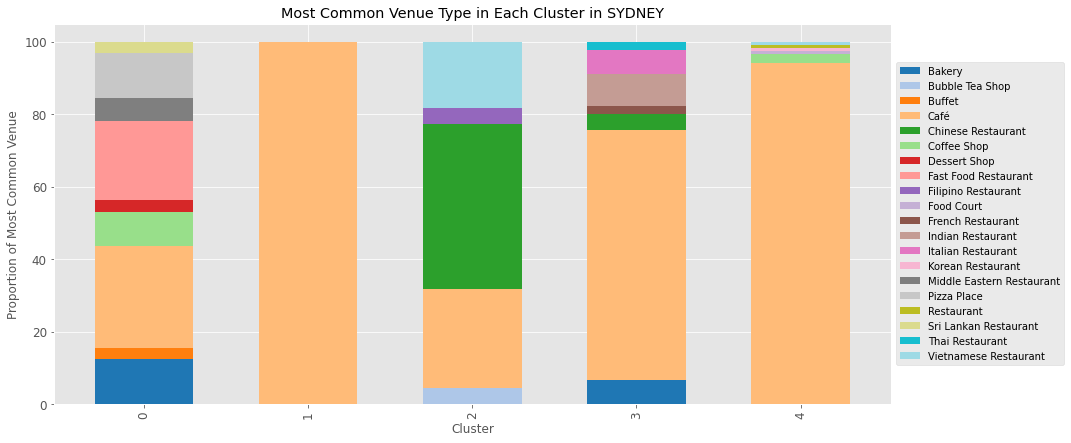

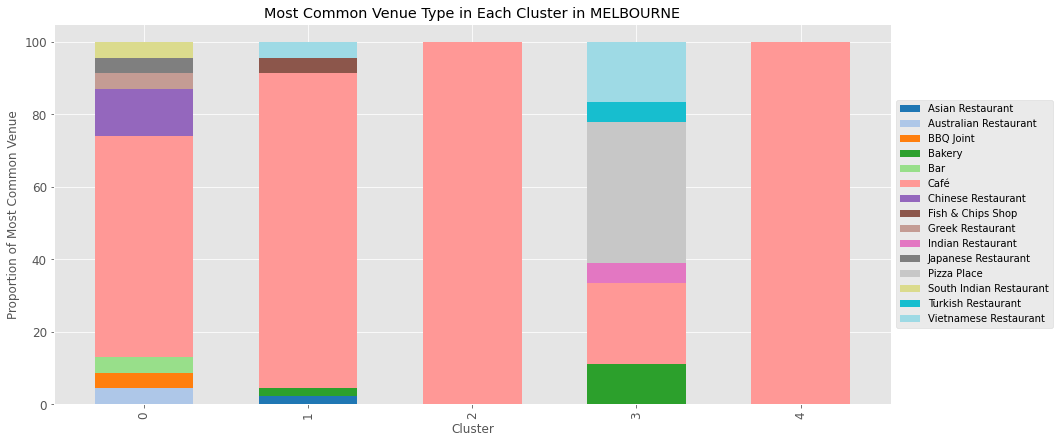

In [20]:
# Function to display the stacked bar chart
def stacked_venue_plt(df, venue_types, city):
    # Create datafram for stacked bar chart
    cluster_venue = df.pivot(index='Cluster Labels', columns='Venue', values='Count')
    cluster_venue = cluster_venue.fillna(0).astype(int).reset_index(drop=True)

    # Convert from frequency to percentage
    stacked_data = cluster_venue.apply(lambda x : x*100/sum(x), axis=1)

    # Set color scheme for the stacked bars
    cmap = cm.get_cmap('tab20', venue_types)
    fig, axs = plt.subplots(1, 1, figsize = (15, 7))

    # Create the stacked bar chart
    stacked_data.plot(kind = 'bar',
                  ax = axs,
                  stacked = True,
                  color = cmap.colors,
                  fontsize = 12,
                  width = 0.6,
                  xlabel = 'Cluster',
                  ylabel = 'Proportion of Most Common Venue',
                  title = f'Most Common Venue Type in Each Cluster in {city}',
                  legend = None)
    axs.legend(bbox_to_anchor=(1, 0.5), loc='center left', labels=stacked_data.columns)
    fig.set_facecolor('white')

stacked_venue_plt(syd_top_venues, syd_venue_types, 'SYDNEY')
stacked_venue_plt(mel_top_venues, mel_venue_types, 'MELBOURNE')